In [3]:
import pandas as pd
import numpy as np


def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

df = get_data([210807, 210814, 210821,210828, 210904, 210911 , 210918, 210925])
df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1676745 entries, 0 to 210399
Data columns (total 11 columns):
 #   Column                                                                Non-Null Count    Dtype 
---  ------                                                                --------------    ----- 
 0   C/A                                                                   1676745 non-null  object
 1   UNIT                                                                  1676745 non-null  object
 2   SCP                                                                   1676745 non-null  object
 3   STATION                                                               1676745 non-null  object
 4   LINENAME                                                              1676745 non-null  object
 5   DIVISION                                                              1676745 non-null  object
 6   DATE                                                                  1676745 non-n

In [4]:
df.rename(columns=lambda x: x.strip(), inplace= True)

In [5]:
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [6]:
df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [7]:
ts_daily = (df
            .groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME" ,"DATE_TIME"],as_index=False)
            .ENTRIES.first())


In [8]:
ts_daily[["PREV_DATE", "PREV_ENTRIES"]] = (ts_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME"])["DATE_TIME","ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

ts_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

<ipython-input-8-ab6322c01a46>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ts_daily[["PREV_DATE", "PREV_ENTRIES"]] = (ts_daily


In [9]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
ts_daily["ENTRIESbydt"] = ts_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

167790067 702272.0
151 5610355.0
35 9769328.0
33565227 188201.0
31 8724126.0
66 3272795.0
15848006 2216515.0
2216520 15848006.0
10487784 2024.0
2024 10487784.0
14 1198448.0
23 705357551.0
6 16034831.0
34 6214051.0
37 1950780.0
173 15689534.0
8 1255797.0
11123659 4624026.0
5 11123659.0
1891101745 1104755.0
43 3154069.0
56 3102579.0
19 2570919.0
50362839 251769.0
26 6250045.0
67 1040931990.0
94 3530461.0
5 1309264042.0
1309264152 5.0
201331802 798740.0
25 5768873.0
1089962288 146746691.0
3538954 51735380.0
0 2030205.0
37 7682472.0
1189019447 3740789.0
346167 14045092.0
14049774 346213.0
774447 9475375.0
9480674 774522.0
7979566 789214.0
794786 7979671.0
1278449 8197329.0
8204122 1278639.0
635 4005927.0
4006679 635.0
8 1684120.0
23 6481464.0
34 1383110353.0


In [10]:
ts_daily.drop(columns=['PREV_DATE', 'PREV_ENTRIES','ENTRIES'] ,inplace= True)

In [11]:
ts_daily

,C/A,UNIT,SCP,STATION,LINENAME,DATE_TIME,ENTRIESbydt
1,A002,R051,02-00-00,59 ST,NQR456W,2021-07-31 04:00:00,11.0
2,A002,R051,02-00-00,59 ST,NQR456W,2021-07-31 08:00:00,5.0
3,A002,R051,02-00-00,59 ST,NQR456W,2021-07-31 12:00:00,38.0
4,A002,R051,02-00-00,59 ST,NQR456W,2021-07-31 16:00:00,122.0
5,A002,R051,02-00-00,59 ST,NQR456W,2021-07-31 20:00:00,155.0
...,...,...,...,...,...,...,...
1676622,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,2021-09-24 05:00:00,0.0
1676623,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,2021-09-24 09:00:00,0.0
1676624,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,2021-09-24 13:00:00,0.0
1676625,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,2021-09-24 17:00:00,0.0


add day col and take mean entries for each day of the week then choose a day

In [12]:
 mask = (ts_daily.LINENAME.str.contains('1')) 

In [13]:

ts_daily = ts_daily[mask]


In [14]:
ts_daily['DAY'] = ts_daily['DATE_TIME'].dt.day_name()

<ipython-input-14-5fd5b192e335>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_daily['DAY'] = ts_daily['DATE_TIME'].dt.day_name()


In [15]:
weeks = ts_daily.groupby('DAY').mean()


In [16]:
mask = (ts_daily.DAY == 'Sunday') & (ts_daily.STATION == '34 ST-PENN STA') 
ts_daily = ts_daily[mask]
ts_daily.set_index(["DATE_TIME"],inplace= True)


In [17]:
x = ts_daily.between_time('00:00:00', '12:59:00')
hours = x.groupby(x.index.hour).mean()
h = ['12 AM','2 AM', '4 AM', '6 AM', '8 AM','10 AM', '12 PM']
nh = []
hours

,ENTRIESbydt
DATE_TIME,
0,45.200000
2,44.619289
4,9.652439
6,6.954315
8,8.634146
10,35.700508
12,25.242424


<AxesSubplot:title={'center':'Entries means in morning for line 1 34 ST-PENN STA'}, ylabel='ENTRIESbydt'>

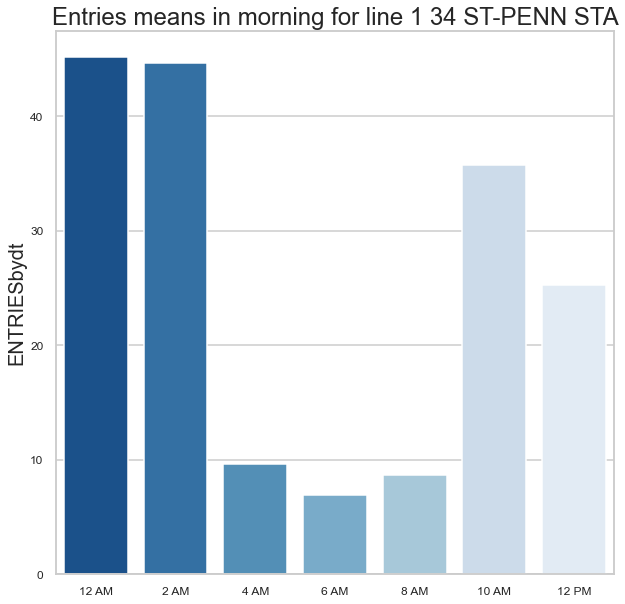

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('presentation.mplstyle')
plt.ylabel('Individual Entries')
plt.title("Entries means in morning for line 1 34 ST-PENN STA")

sns.set_style("whitegrid")
sns.set_context("talk")
sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
sns.barplot( x = h ,y = hours.ENTRIESbydt, data= hours,palette= "Blues_r")